In [1]:
from Pipeline import BLEPipeline, WifiPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score

# System libraries
from itertools import izip, combinations
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create dataset

In [2]:
time_start = time.time()

In [3]:
w = WifiPipeline()

In [4]:
# w.extract_packet_features(create_master=True)

In [5]:
df = w.make_dataframe()

# Take out packets from router
df = df[df["DeviceType"]!="router"]


Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64


## Data Exploration

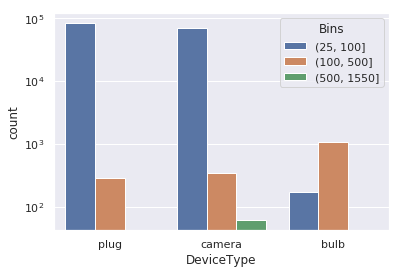

In [35]:
g = sns.countplot(x=df['DeviceType'], hue=pd.cut(df['PacketLength'], bins=[25,100,500,1550]));
g.set_yscale('log')
plt.legend(title='Bins', loc='upper_right');

Belkin     93477
Dropcam    45912
Tp-link    17713
Lifi        1040
Name: Vendor, dtype: int64


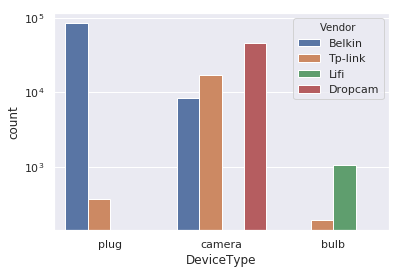

In [36]:
g = sns.countplot(x=df["DeviceType"], hue=df["Vendor"]);
g.set_yscale('log')
print df['Vendor'].value_counts()

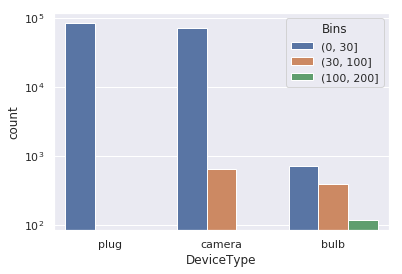

In [37]:
g = sns.countplot(x=df['DeviceType'], hue=pd.cut(df['Assoc_Packets'], bins=[0,30,100,200]));
g.set_yscale('log')
plt.legend(title='Bins', loc='upper_right');

QoS_Null    132500
QoS_Data     20539
Data          5103
Name: Subtype, dtype: int64


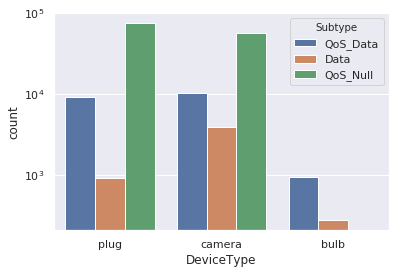

In [38]:
g = sns.countplot(x=df["DeviceType"], hue=df["Subtype"]);
g.set_yscale('log')
print df['Subtype'].value_counts()

## Resample

### Downsampling

In [10]:
df_train = df[df['Set']=='train']

# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'SourceAddr', 'Set', 'SubtypeNum'}
onehotEncoded_vars = {'Belkin', 'Data', 'Dropcam', 
                      'Lifi', 'Netgear', 'QoS_Data', 'QoS_Null', 'Tp-link'}
response_vars = {"DeviceType","bulb","camera","router","plug"}

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | set(['Subtype', 'Vendor'])
X = df_train.drop(col_drop, axis=1)

In [11]:
df_train['DeviceType'].value_counts()

plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64

### Create downsampled trial dataframes

In [12]:
df_trials = []
num_trials = 10
for i in range(0,num_trials):
    # Down
    df_downsampled = w.downsample(X, y, df[df["Set"]=="test"])
    df_trials.append(df_downsampled)

In [13]:
# Wifi: Define which features to use
features_list = [
        # Packet info
        "PacketLength",
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

# Define what the response classes are
y_list = ["camera", "bulb", "plug"]

# Run trials

In [14]:
trial_results = []
for i, trial in enumerate(df_trials):
    print "Trial", i+1
    result = w.one_vs_all_classify(trial, features_list, y_list)
    trial_results.append(result)

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


## Reports/Plots

### AUC

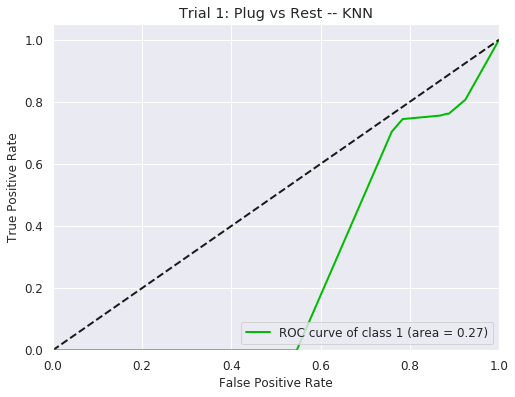

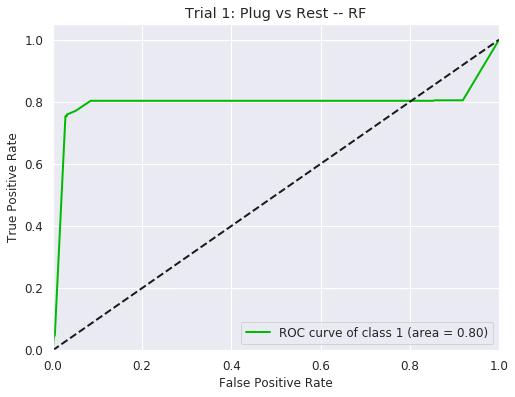

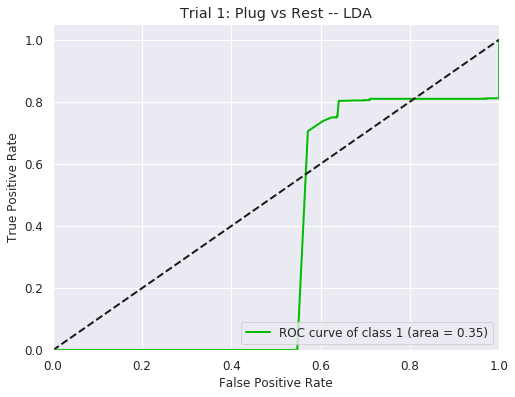

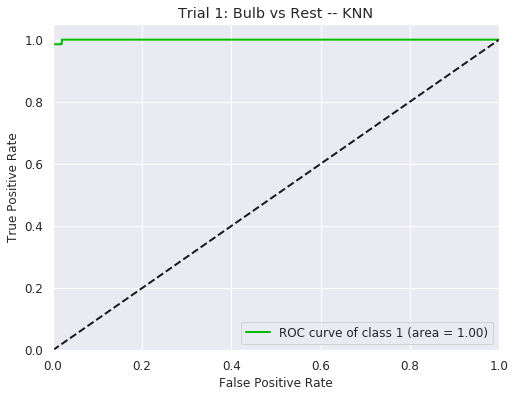

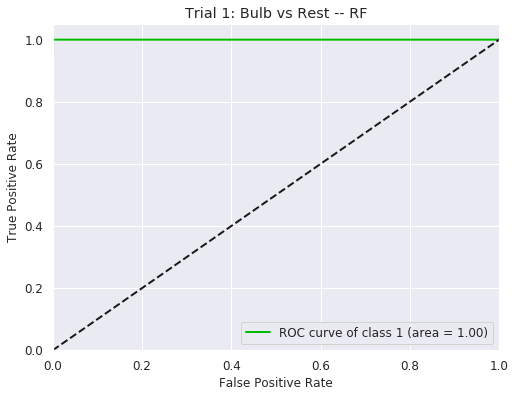

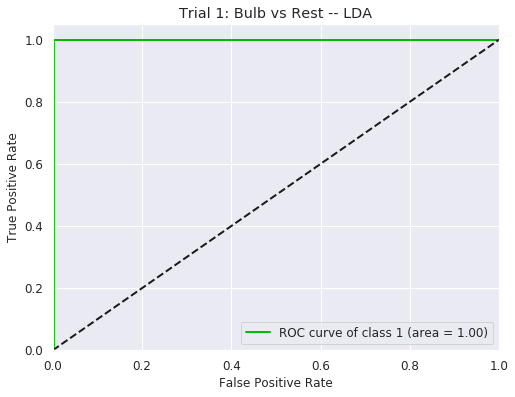

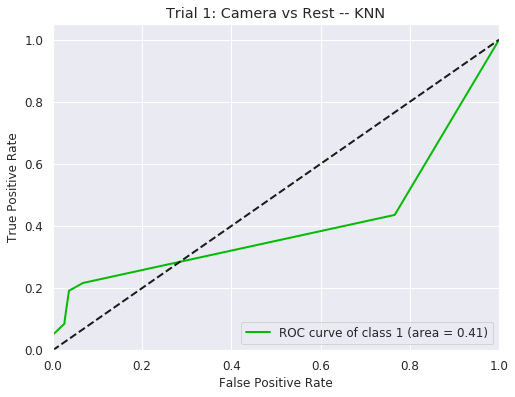

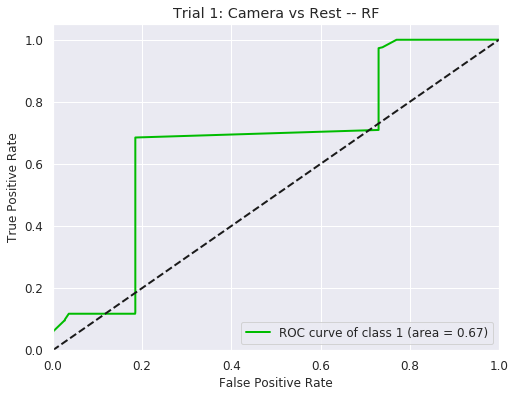

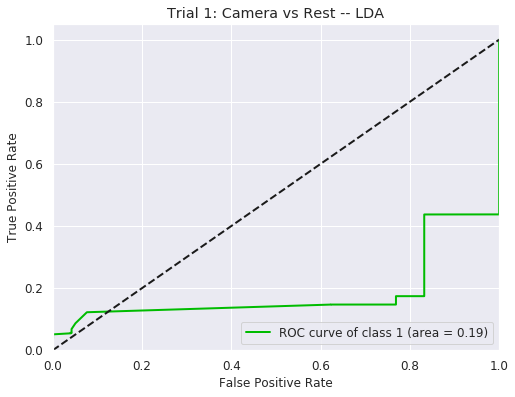

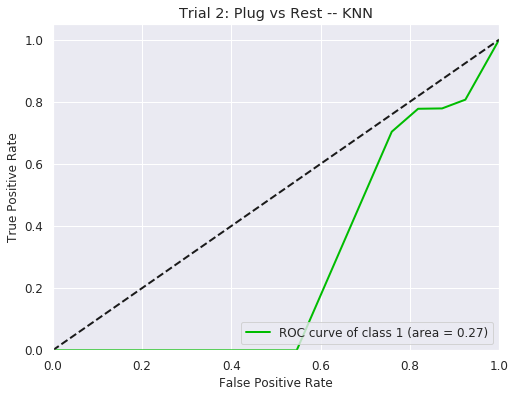

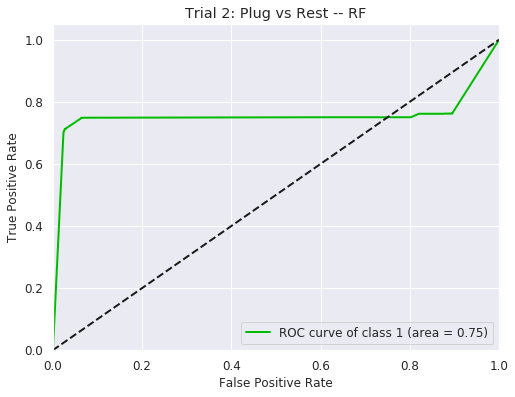

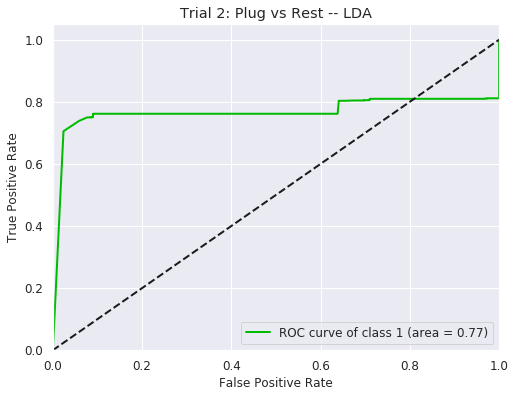

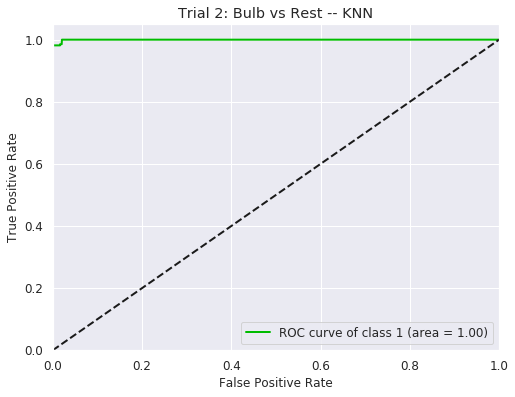

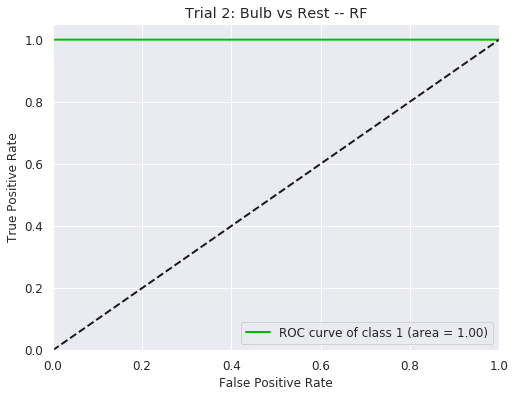

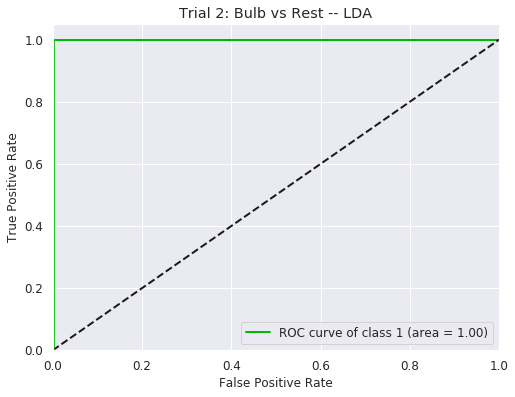

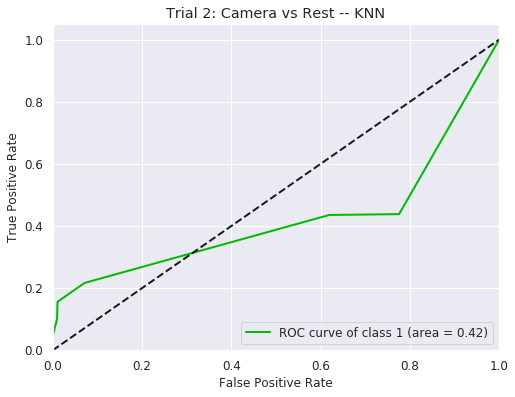

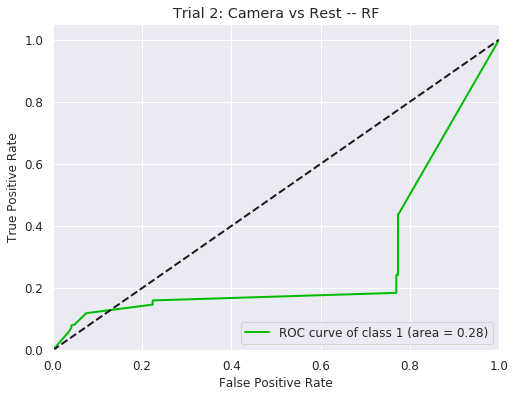

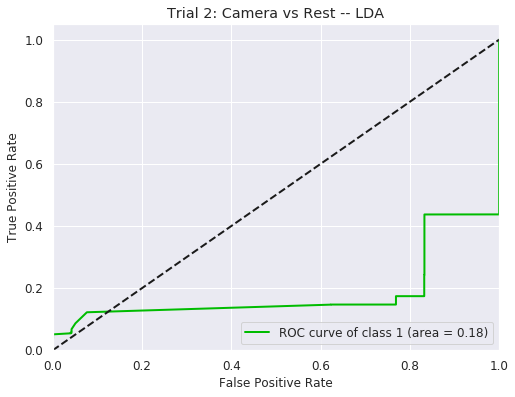

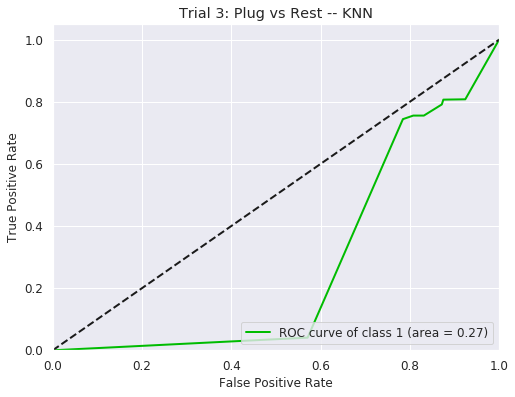

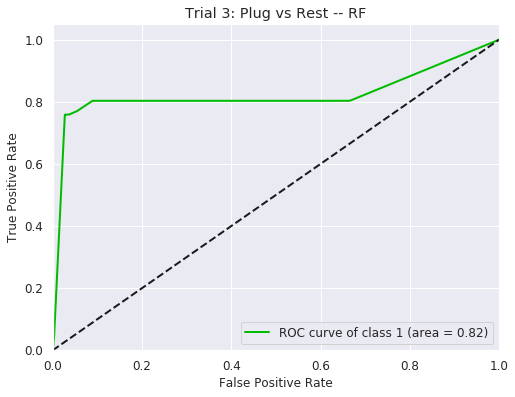

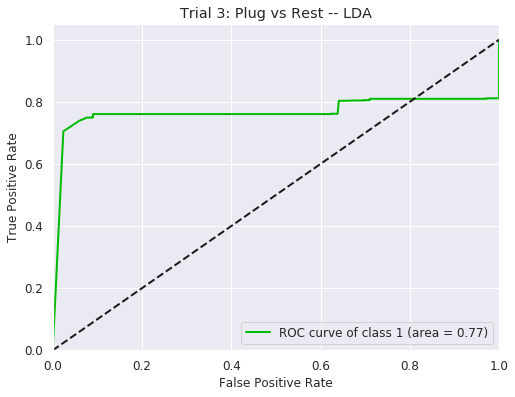

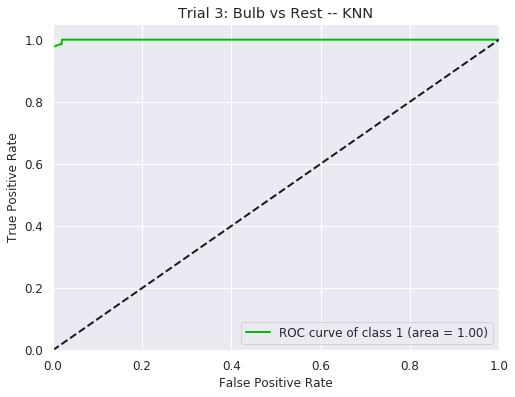

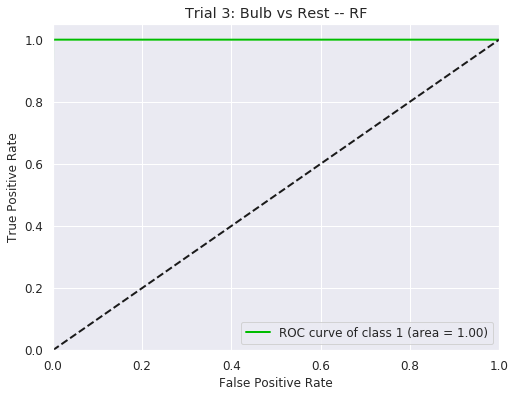

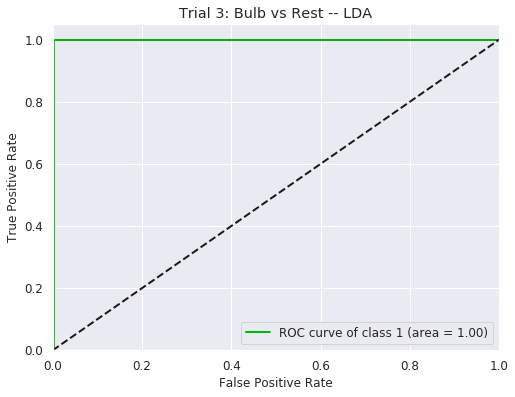

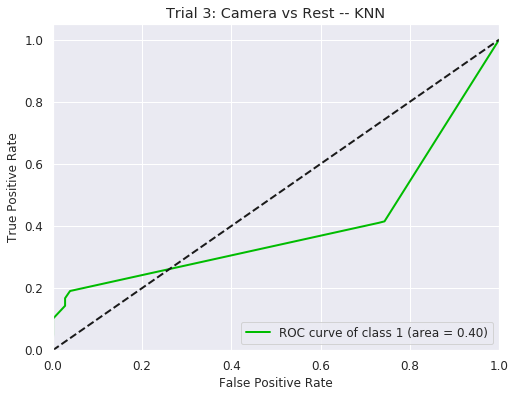

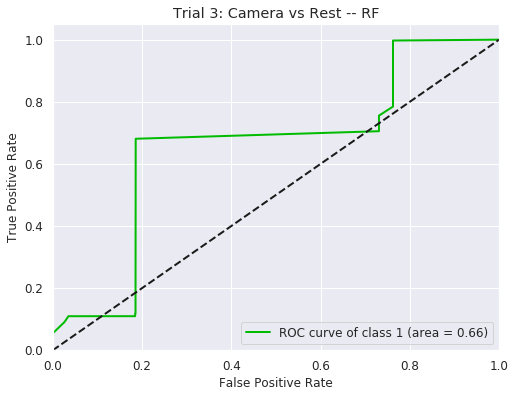

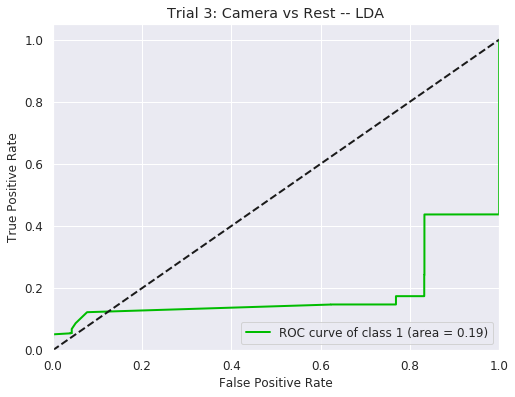

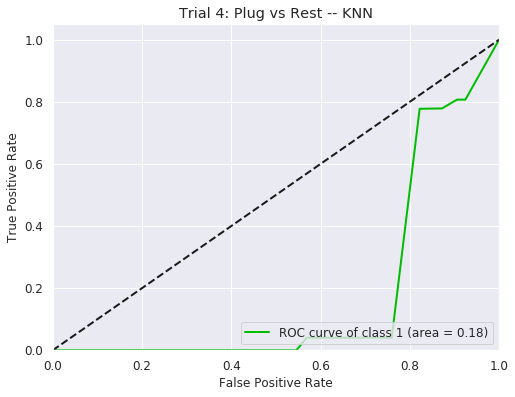

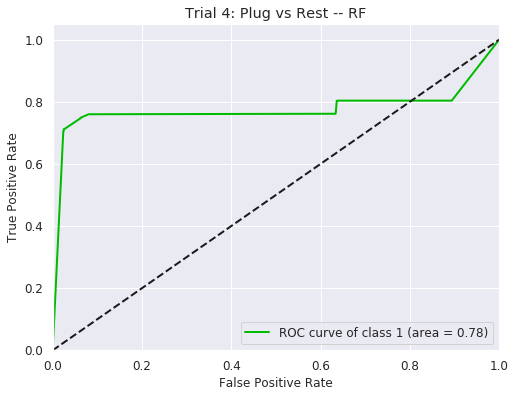

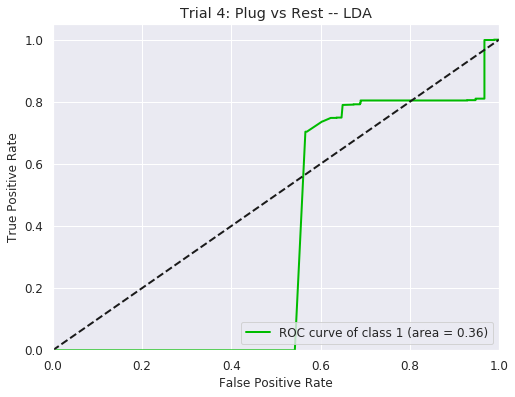

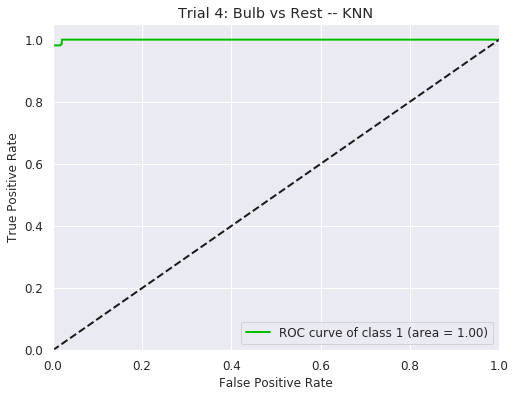

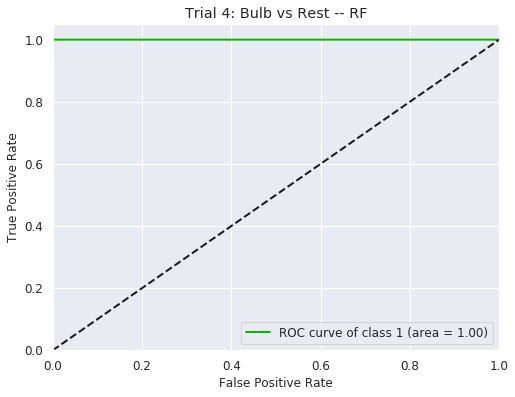

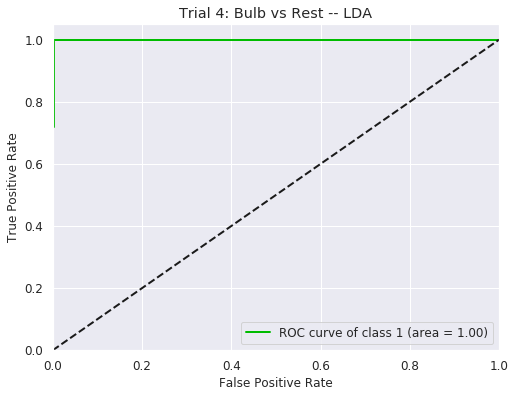

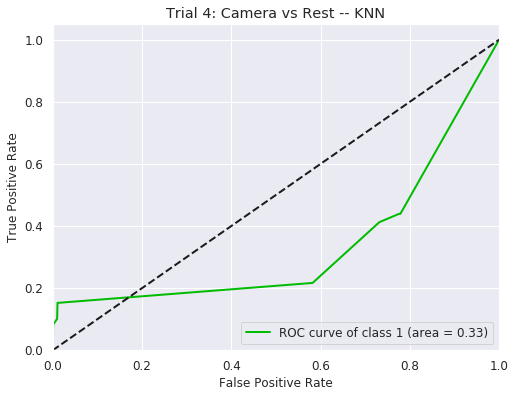

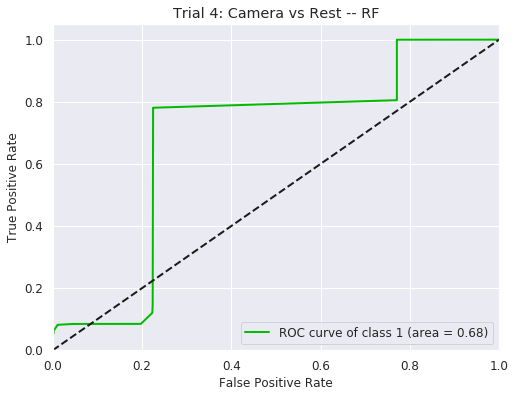

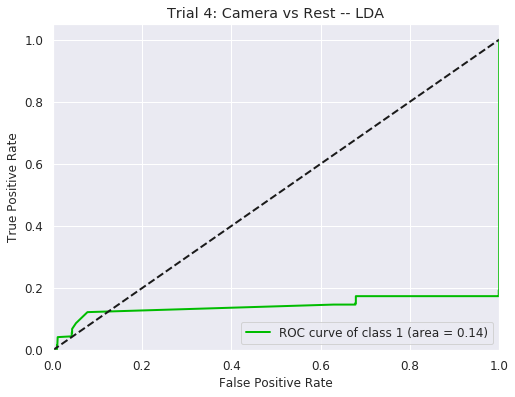

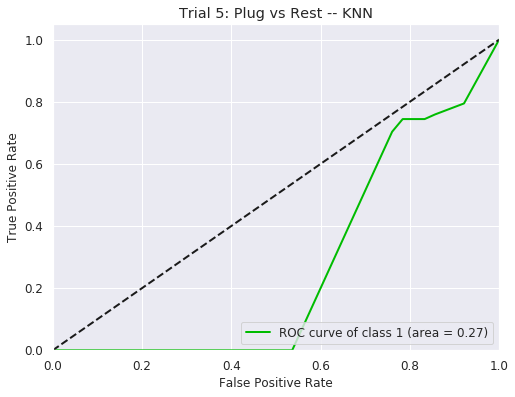

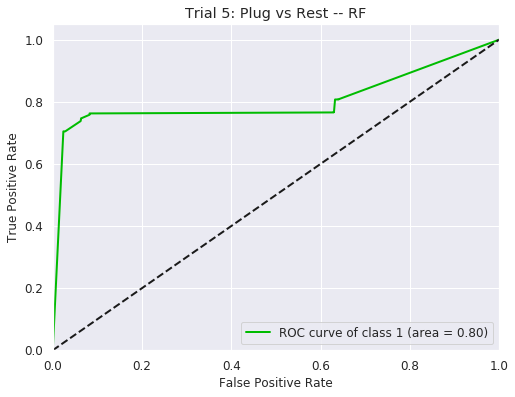

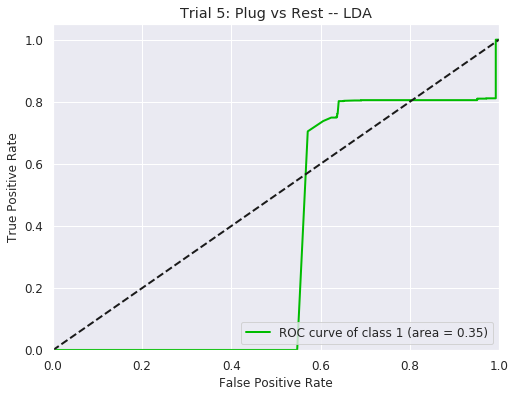

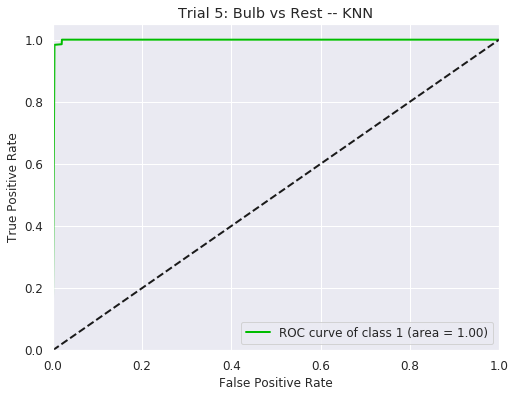

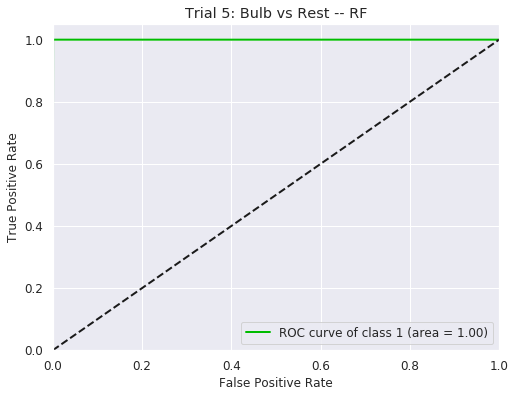

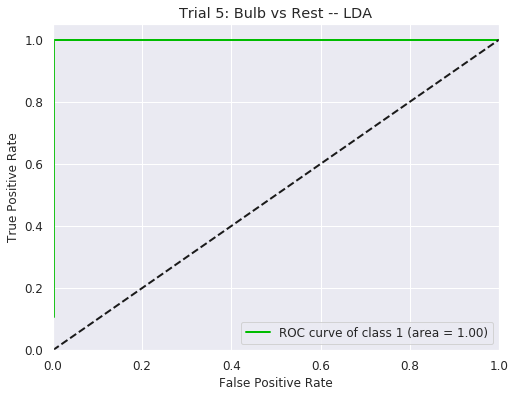

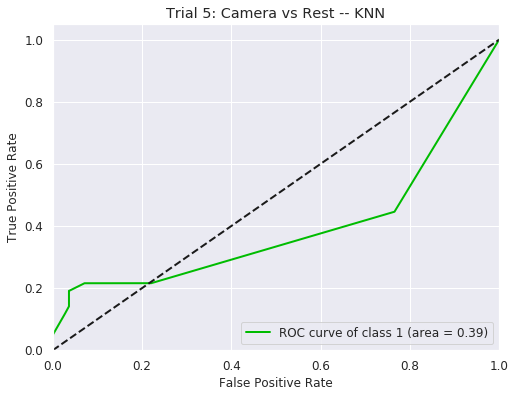

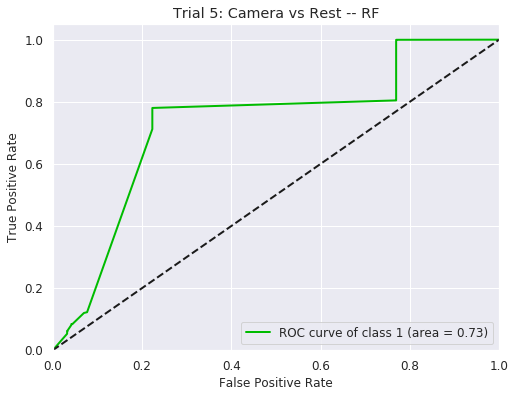

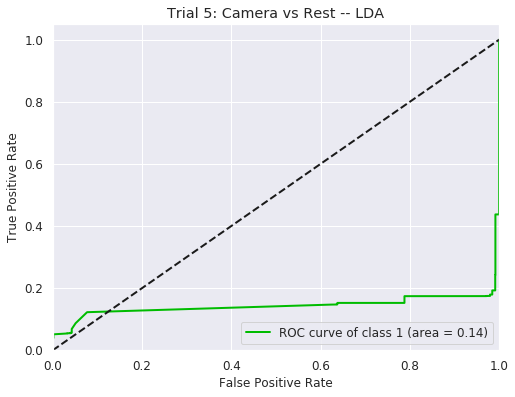

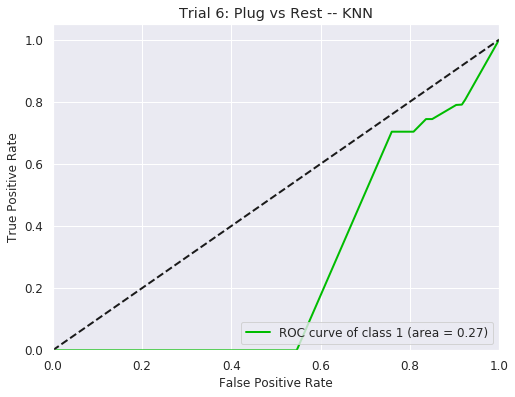

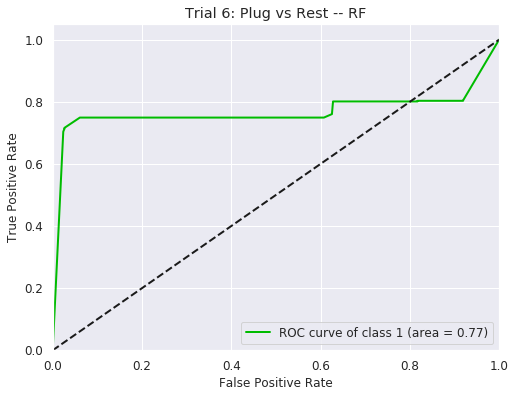

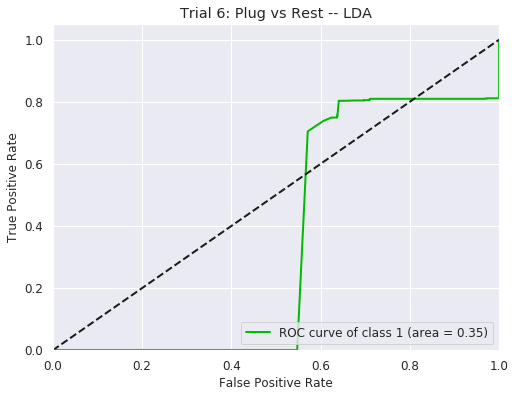

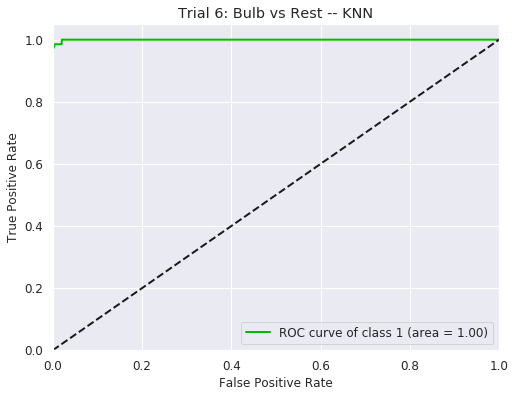

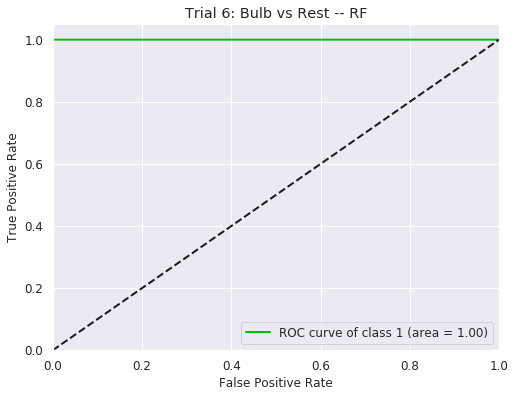

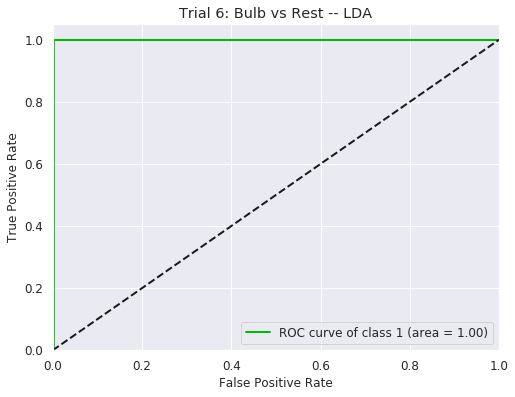

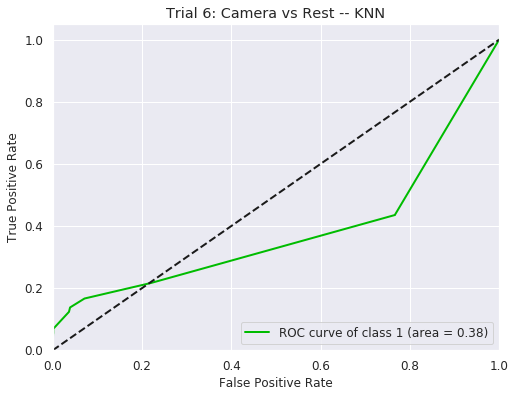

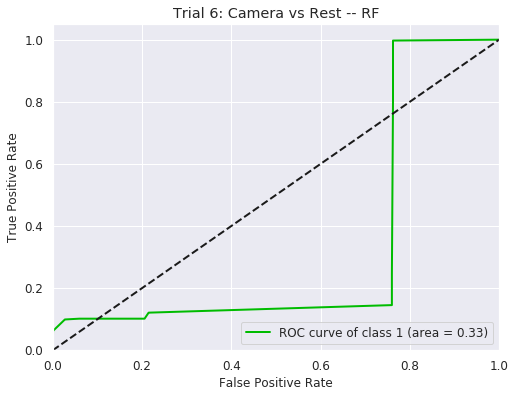

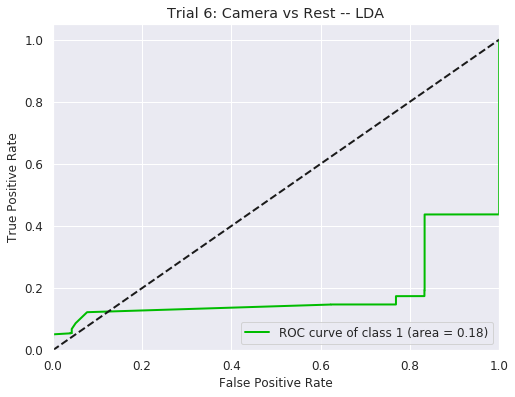

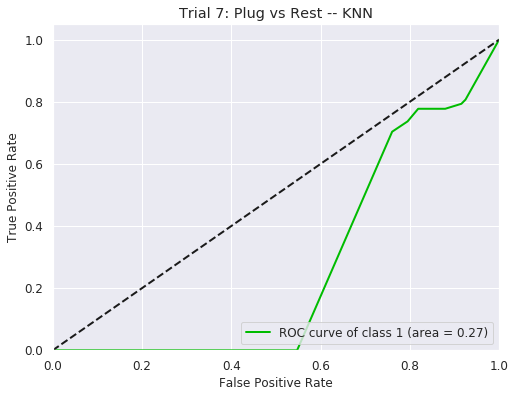

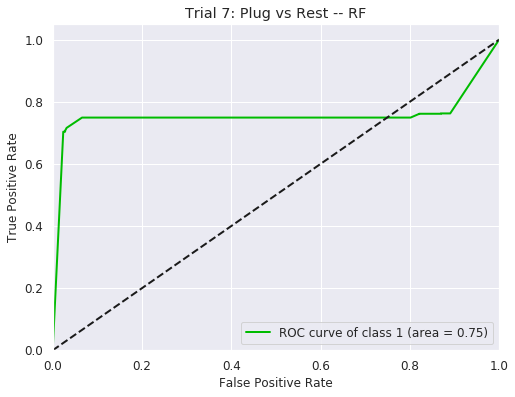

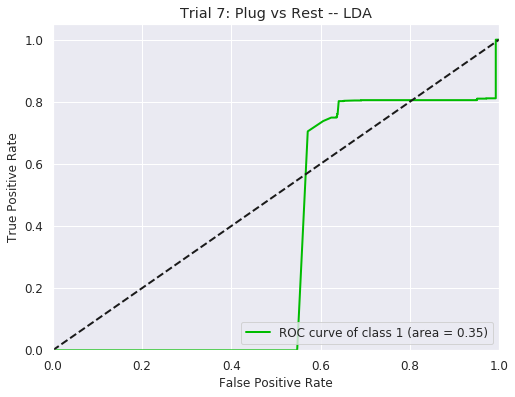

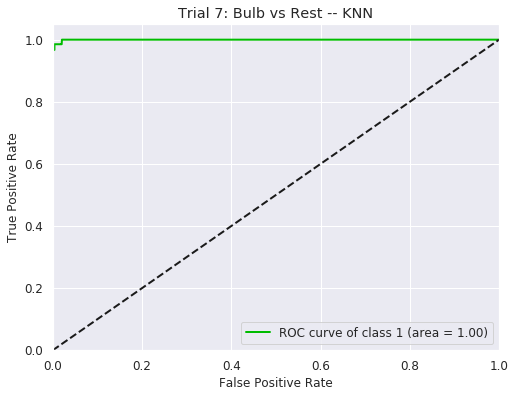

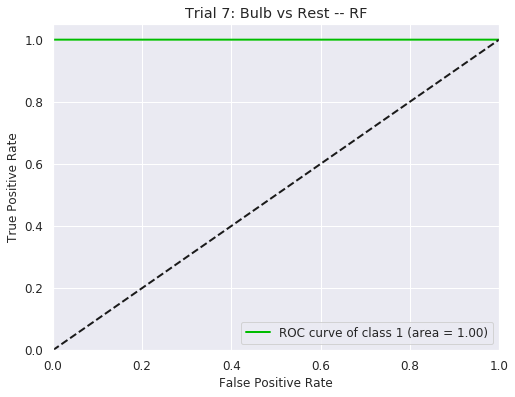

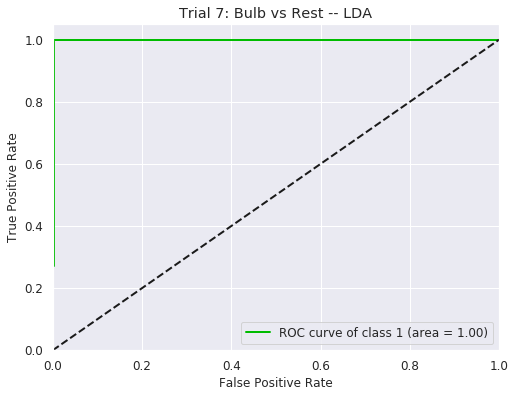

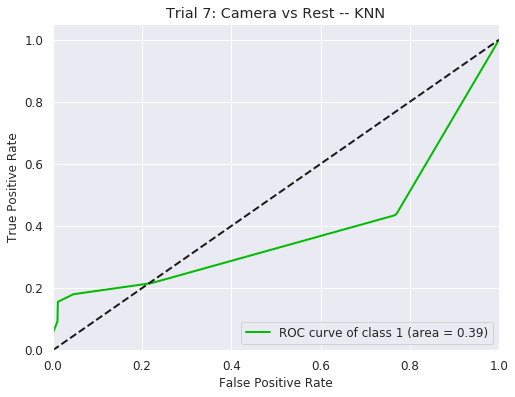

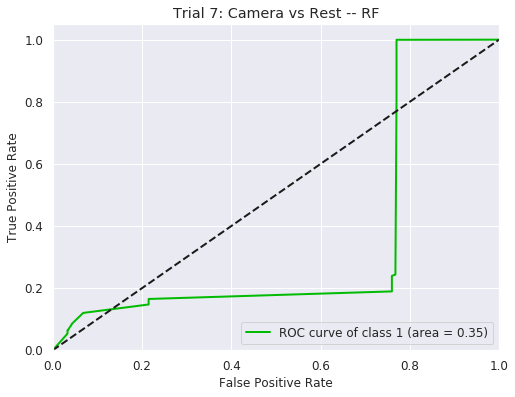

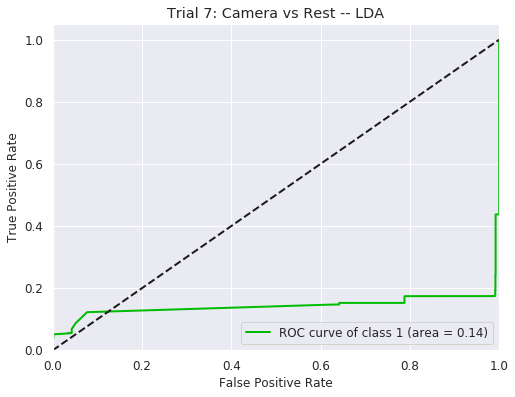

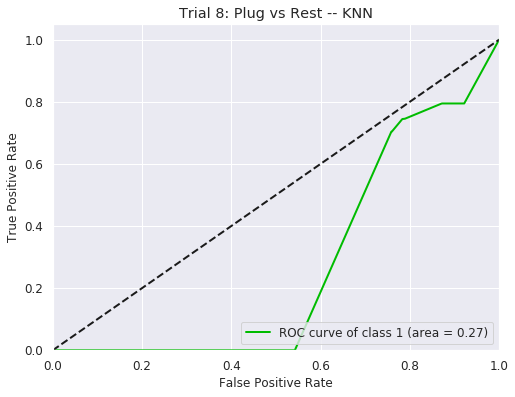

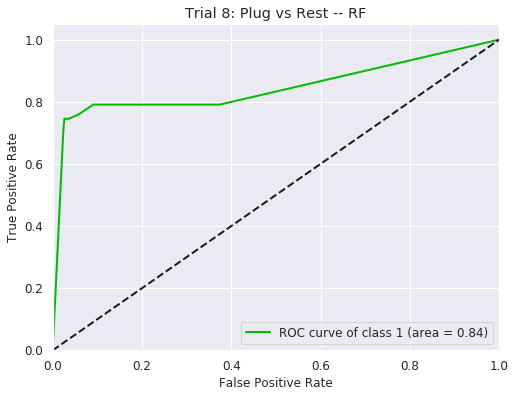

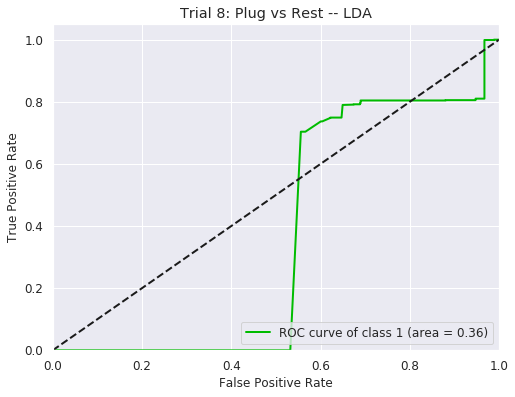

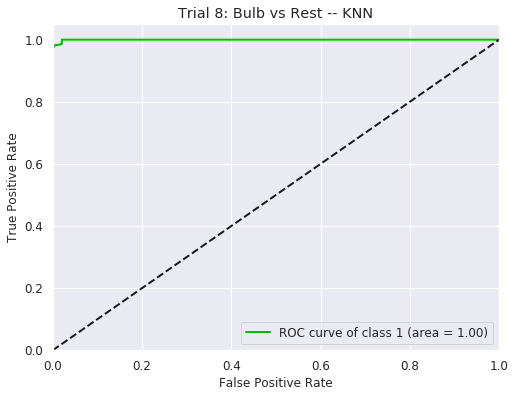

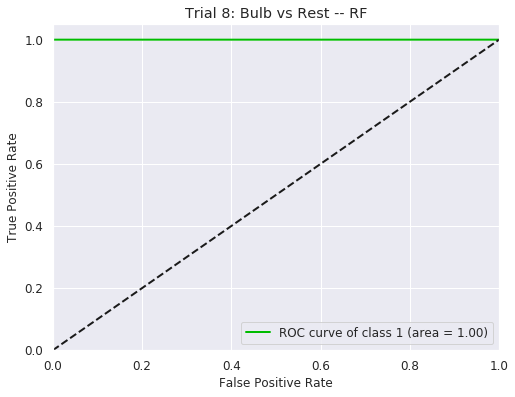

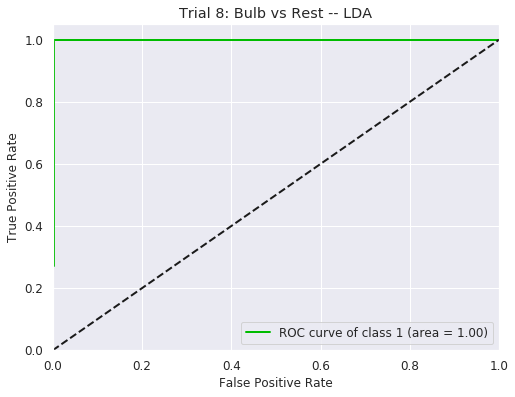

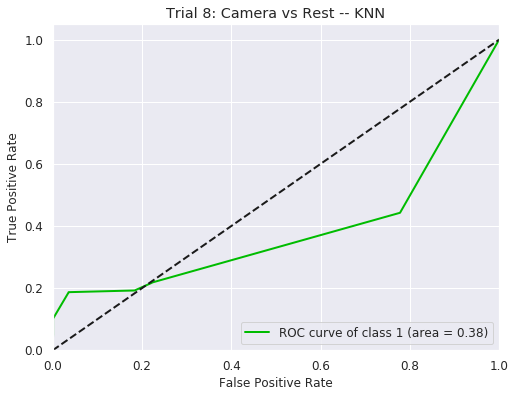

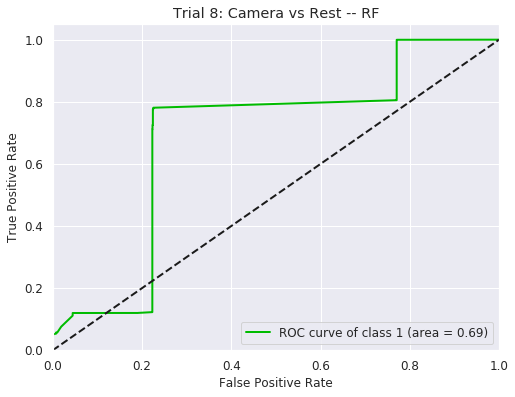

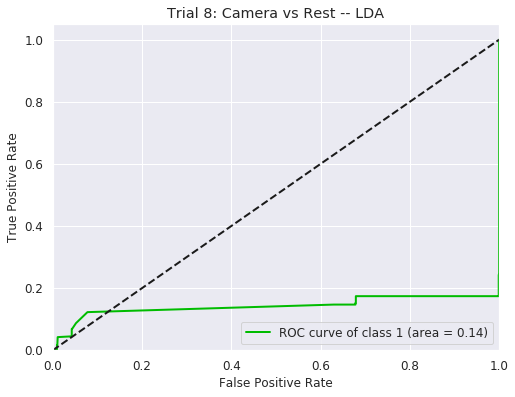

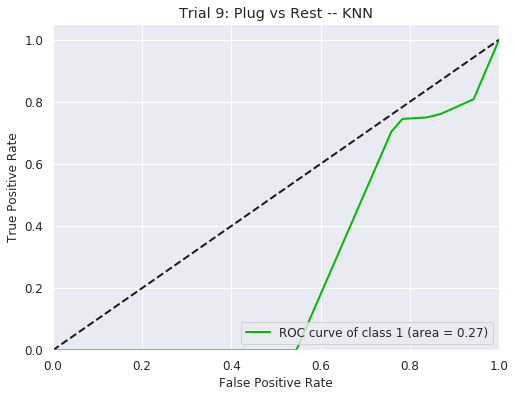

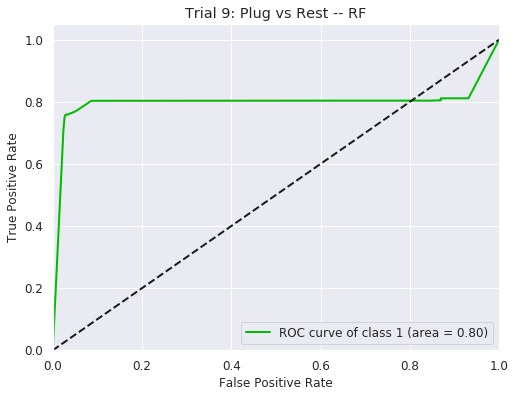

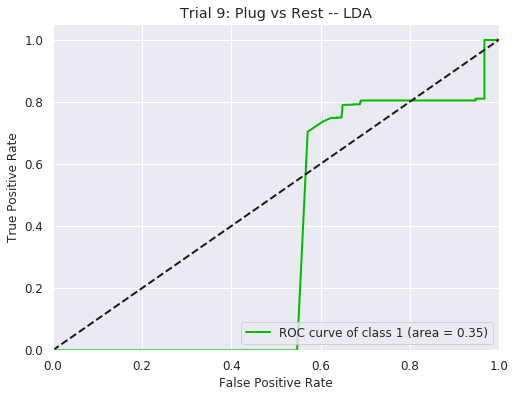

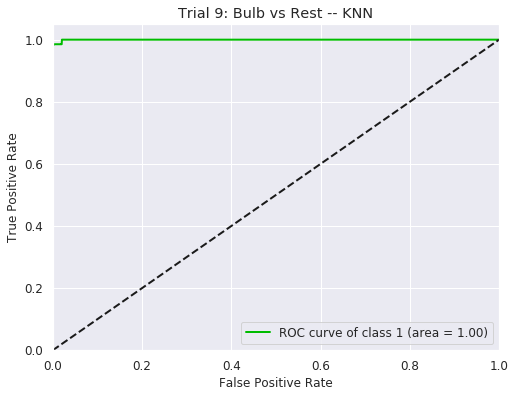

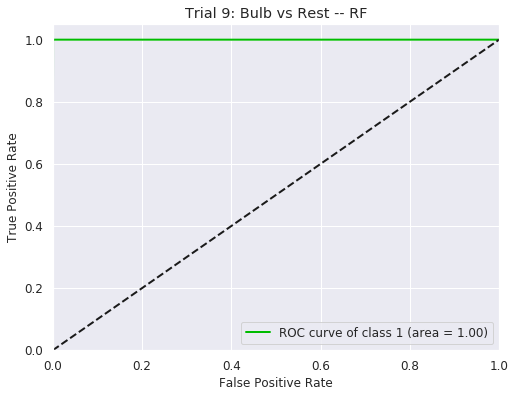

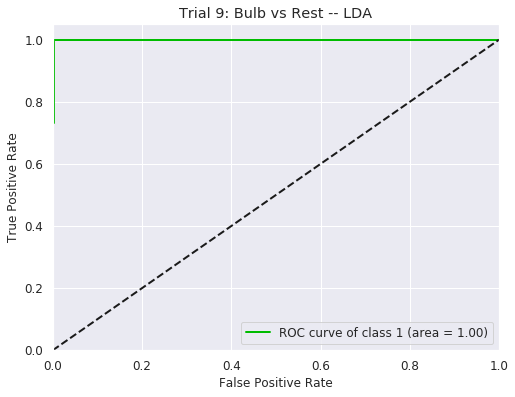

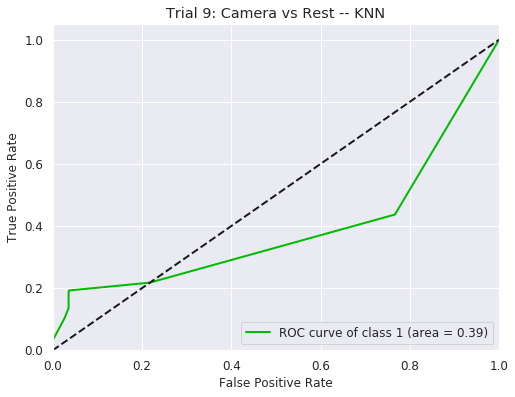

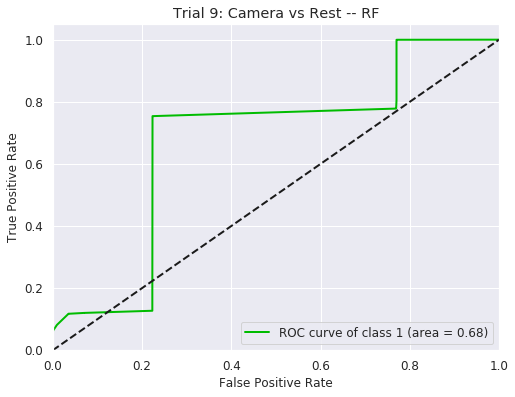

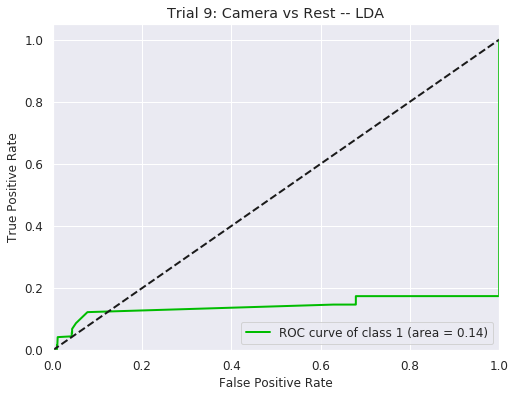

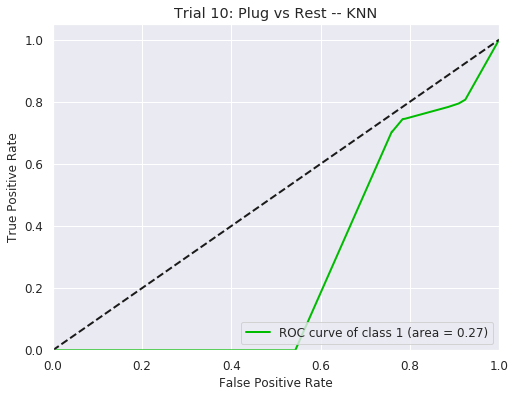

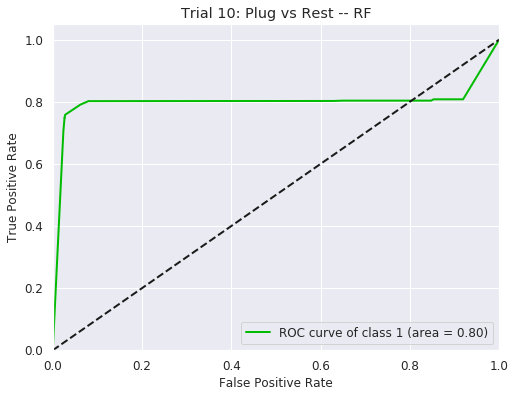

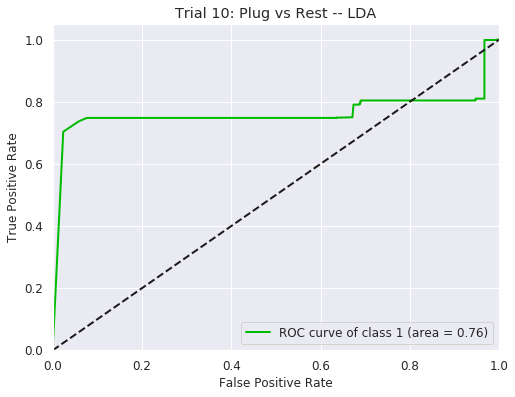

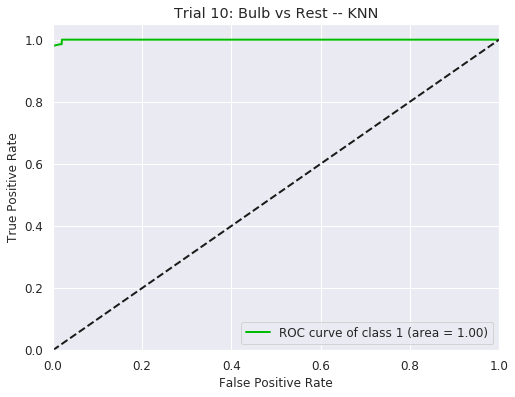

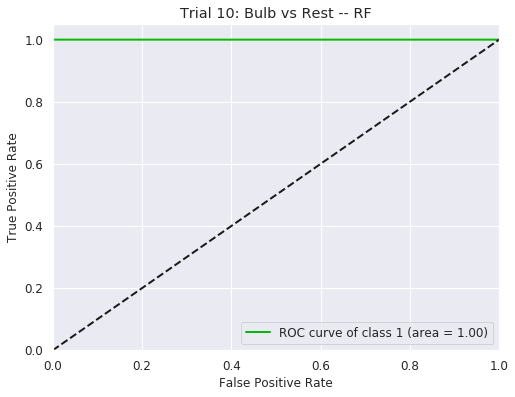

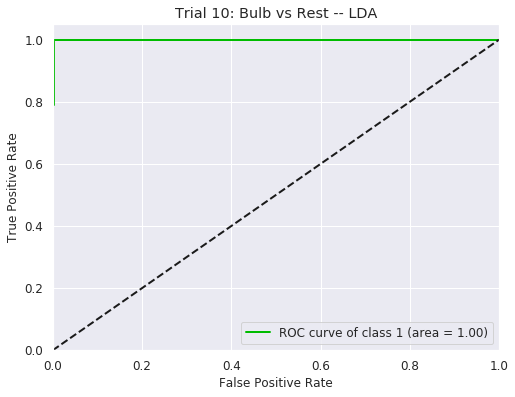

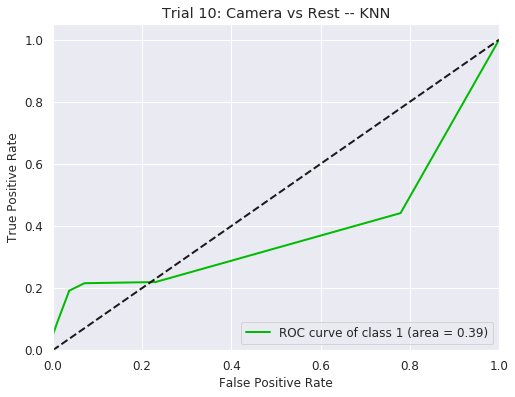

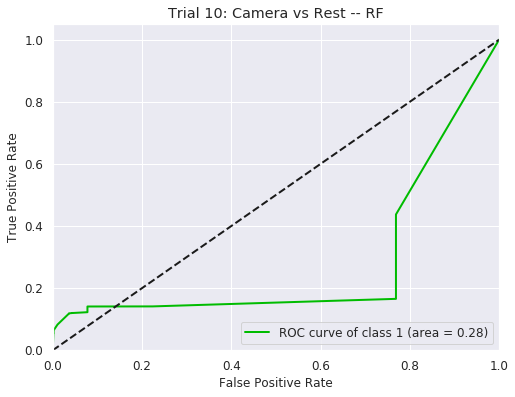

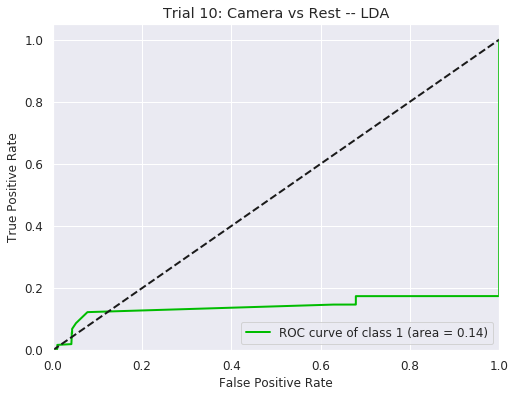

In [15]:
# Plotting ROC curves
sns.set(font_scale=1)
aucs = []

for trial_num, result in enumerate(trial_results):
    # Extract devices and classifiers
    dev_pairs = result[0].keys()
    classifiers = result[0][dev_pairs[0]].keys()

    for device in dev_pairs:
        for classifier in classifiers:
            # Extract predicted probas and y_true
            pred_proba = result[0][device][classifier]['Classifier']['Pred_Proba']
            true = result[0][device][classifier]['Classifier']['True']
            
            # Calculate, store auc
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            aucs.append(auc)            
            
            # Plot ROC curve
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            title = "Trial " + str(trial_num + 1) + ": " + str(device).capitalize() + " vs Rest -- " + str(classifier).upper() 
            skplt.metrics.plot_roc(true, pred_proba, title=title, plot_micro=False, plot_macro=False, 
                                   classes_to_plot=[1], figsize=(8,6));

### Print csv results

In [16]:
df_alloutput = w.store_trial_results(trial_results)
df_alloutput['AUC'] = aucs
df_alloutput.to_csv('Results/wifi-alltrials.csv', mode='w')

In [17]:
cm_metrics = ['TP','FP','FN','TN']
performance_metrics = ['Accuracy', 'Precision','Recall','AUC']

df_meancm = pd.DataFrame(columns= w.get_header(cm_metrics))
df_meanmetrics = pd.DataFrame(columns= w.get_header(performance_metrics))

devalg_combinations = [(x,y) for x in df_alloutput['Device'].unique() for y in df_alloutput['Classifier'].unique()]
for x in devalg_combinations:    
    # Report mean confusion matrix
    cm = df_alloutput.loc[(df_alloutput['Device']==x[0]) & (df_alloutput['Classifier']==x[1]), cm_metrics]
    mean_cm = w.get_mean_metric(cm, cm_metrics)
    mean_cm_series = pd.Series(data=mean_cm, name=str(x), index=df_meancm.columns)
    df_meancm = df_meancm.append(mean_cm_series)
    
    # Report mean performance metrics
    metrics = df_alloutput.loc[(df_alloutput['Device']==x[0]) & (df_alloutput['Classifier']==x[1]), performance_metrics]
    mean_metrics = w.get_mean_metric(metrics, performance_metrics)
    mean_metrics_series = pd.Series(data=mean_metrics, name=str(x), index=df_meanmetrics.columns)
    df_meanmetrics = df_meanmetrics.append(mean_metrics_series)

# Print out to csv    
df_meancm.to_csv('Results/wifi-meanCM.csv', mode='w')
df_meanmetrics.to_csv('Results/wifi-meanmetrics.csv', mode='w')

In [18]:
df_performance_device = w.report_metrics_across('Device', df_alloutput)
display(df_performance_device)
df_performance_device.to_csv('Results/wifi-devtype.csv', mode='w')

,Accuracy,SD_Accuracy,CI_Accuracy,Recall,SD_Recall,CI_Recall,Precision,SD_Precision,CI_Precision,AUC,SD_AUC,CI_AUC
plug,0.613509,0.213573,0.079319,0.669929,0.227512,0.084496,0.305544,0.301571,0.112001,0.509860,0.248681,0.092358
bulb,0.976176,0.035853,0.013315,0.995107,0.007038,0.002614,0.609810,0.295797,0.109856,0.998792,0.001203,0.000447
camera,0.507128,0.089454,0.033223,0.123048,0.048078,0.017856,0.915757,0.094441,0.035075,0.360903,0.191525,0.071131


In [19]:
df_performance_classifier = w.report_metrics_across('Classifier', df_alloutput)
display(df_performance_classifier)
df_performance_classifier.to_csv('Results/wifi-classifier.csv', mode='w')

,Accuracy,SD_Accuracy,CI_Accuracy,Recall,SD_Recall,CI_Recall,Precision,SD_Precision,CI_Precision,AUC,SD_AUC,CI_AUC
KNN,0.676600,0.223768,0.083105,0.637227,0.346685,0.128756,0.535312,0.374114,0.138942,0.549330,0.328480,0.121994
RF,0.779646,0.199479,0.074085,0.614279,0.378950,0.140738,0.786294,0.239463,0.088934,0.775372,0.222079,0.082478
LDA,0.640567,0.281742,0.104636,0.536579,0.431743,0.160345,0.509506,0.366454,0.136097,0.544853,0.368445,0.136837


In [20]:
device_types = ['bulb', 'camera', 'plug']
classifiers = ['KNN', 'LDA', 'RF']

### Time Performance

In [22]:
for trial_num, result in enumerate(trial_results):
    print "Trial ", trial_num
    print "Total time:", result[1], "seconds"
    
    for device in device_types:
        for classifier in classifiers:
            title = "("+ str(device).capitalize() + ", "+str(classifier).upper() + ")"
            print title, ":", result[0][device][classifier]['Classifier']['Time'], "seconds"
    
    print ""

Trial  0
Total time: 3.21428990364 seconds
(Bulb, KNN) : 0.675081968307 seconds
(Bulb, LDA) : 0.0103321075439 seconds
(Bulb, RF) : 0.0674960613251 seconds
(Camera, KNN) : 0.7960460186 seconds
(Camera, LDA) : 0.0294468402863 seconds
(Camera, RF) : 0.116149187088 seconds
(Plug, KNN) : 0.669907808304 seconds
(Plug, LDA) : 0.0109021663666 seconds
(Plug, RF) : 0.0701470375061 seconds

Trial  1
Total time: 2.87602591515 seconds
(Bulb, KNN) : 0.616106987 seconds
(Bulb, LDA) : 0.0105381011963 seconds
(Bulb, RF) : 0.0669100284576 seconds
(Camera, KNN) : 0.652580022812 seconds
(Camera, LDA) : 0.0105719566345 seconds
(Camera, RF) : 0.0715599060059 seconds
(Plug, KNN) : 0.621651887894 seconds
(Plug, LDA) : 0.0104789733887 seconds
(Plug, RF) : 0.0715191364288 seconds

Trial  2
Total time: 2.99375700951 seconds
(Bulb, KNN) : 0.727275133133 seconds
(Bulb, LDA) : 0.0101177692413 seconds
(Bulb, RF) : 0.065908908844 seconds
(Camera, KNN) : 0.618805885315 seconds
(Camera, LDA) : 0.0105159282684 seconds
(

### Feature Importance

In [23]:
# Extract feature importance values
df_featImp = pd.DataFrame()
for i,f in enumerate(w.feature_importances):
    f_i = pd.Series(f, index=features_list)
    df_featImp[i] = f_i

In [24]:
df_featImp['Mean'] = df_featImp.mean(axis=1)
df_featImp['StdDev'] = df_featImp.std(axis=1)
df_featImp['CI_MOE'] = (2*df_featImp['StdDev']) / np.sqrt(len(df_featImp)-1)

In [25]:
feat_imp = df_featImp[['Mean', 'StdDev', 'CI_MOE']].sort_values('Mean', ascending=False)
display(feat_imp)
feat_imp.to_csv('Results/wifi-feature_importance.csv', mode='w')

,Mean,StdDev,CI_MOE
Belkin,0.213963,0.210653,0.140435
PacketLength,0.201376,0.171705,0.114470
Dropcam,0.188880,0.226899,0.151266
Assoc_Packets,0.133717,0.090304,0.060203
QoS_Null,0.128967,0.121853,0.081235
Lifi,0.073161,0.080102,0.053401
QoS_Data,0.033985,0.038547,0.025698
Data,0.012977,0.011523,0.007682
Tp-link,0.012975,0.021475,0.014317
Netgear,0.000000,0.000000,0.000000


### Sampling Counts

In [26]:
print "Packet Counts Prior to Resampling"
dt_vc = df["DeviceType"].value_counts()
print dt_vc


Packet Counts Prior to Resampling
plug      85512
camera    71399
bulb       1231
Name: DeviceType, dtype: int64


Training Set plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64

Test Set camera    20117
plug       1870
bulb        545
Name: DeviceType, dtype: int64


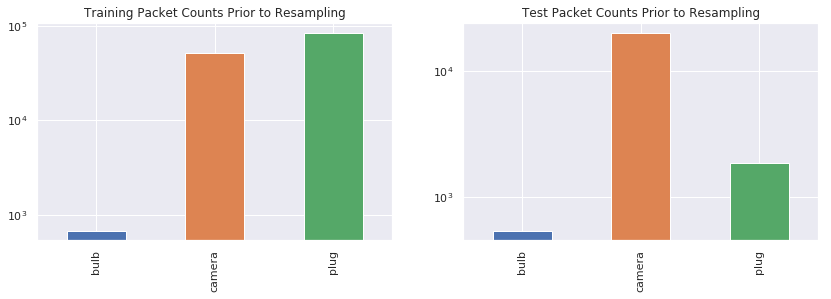

In [27]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling", logy=True);
print "Training Set", df_train["DeviceType"].value_counts()
print

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling", logy=True);
print "Test Set", df_test["DeviceType"].value_counts()

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


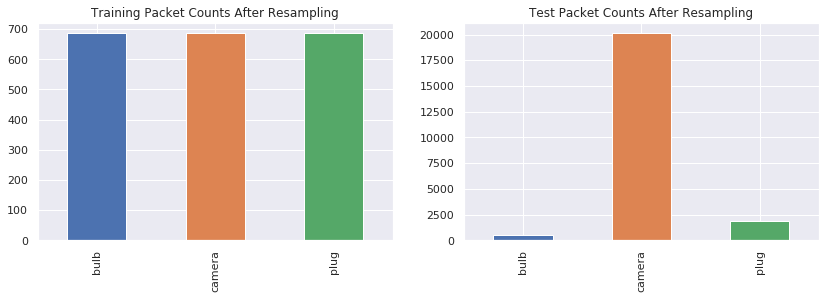

In [28]:
# Plot post-sampling
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

df_train_downsampled = df_trials[0][df_trials[0]['Set']=='train']
df_test_downsampled = df_trials[0][df_trials[0]['Set']=='test']

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[['bulb','camera','plug']].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");
